In [1]:
import datetime; datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

'2022-03-14 13:16:21'

# wip

In [2]:
import mariadb
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
#%matplotlib inline
import seaborn as sns
sns.set(
rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'black',
 'axes.facecolor': 'None',
 'axes.grid': False,
 "grid.color": "lightgrey",
 'axes.labelcolor': 'black',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'black',
 'xtick.bottom': False,
 'xtick.color': 'black',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'black',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False,
    })
plt.rcParams["figure.figsize"] = (30,7)
sns.set_context("notebook", rc={"font.size":20,
                                "axes.titlesize":20,
                                "axes.labelsize":15})
# paper config below (uncomment)

plt.rcParams.update({
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'font.size': 15,
    'figure.autolayout': True,
    'figure.figsize': (7.2,4.45),
    'axes.titlesize' : 16,
    'axes.labelsize' : 17,
    'lines.linewidth' : 2,
    'lines.markersize' : 6,
    'legend.fontsize': '13',
    'mathtext.fontset': 'stix',
    'font.family': 'STIXGeneral',
    
    })

# some irrelavant config
#CB91_Blue = '#2CBDFE'
#CB91_Green = '#47DBCD'
#CB91_Pink = '#F3A0F2'
#CB91_Purple = '#9D2EC5'
#CB91_Violet = '#661D98'
#CB91_Amber = '#F5B14C'
#color_list = [CB91_Purple, CB91_Blue, CB91_Pink, CB91_Green,
#              CB91_Amber, CB91_Violet]
#plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=sns.color_palette("bright"))
sns.color_palette("bright")

[(0.00784313725490196, 0.24313725490196078, 1.0),
 (1.0, 0.48627450980392156, 0.0),
 (0.10196078431372549, 0.788235294117647, 0.2196078431372549),
 (0.9098039215686274, 0.0, 0.043137254901960784),
 (0.5450980392156862, 0.16862745098039217, 0.8862745098039215),
 (0.6235294117647059, 0.2823529411764706, 0.0),
 (0.9450980392156862, 0.2980392156862745, 0.7568627450980392),
 (0.6392156862745098, 0.6392156862745098, 0.6392156862745098),
 (1.0, 0.7686274509803922, 0.0),
 (0.0, 0.8431372549019608, 1.0)]

In [4]:
class DbAccessor:
    def __init__(self, db_name, cfg_primary_key="run_id", timestep_col_name="episode", local=False, gc=False, gc2=False):
        #params:
        #    cfg_primary_key: the key that is used to index the runs
        #    timestep_col_name: the column which contains the timestep values to be used in plots (or any other column to index with/use as x-axis)
        self.cfg_primary_key = cfg_primary_key
        self.timestep_col_name = timestep_col_name
        try:
            if local:
                    self.conn = mariadb.connect(user="haseebs",
                                                password="",
                                                host="localhost",
                                                port=3306,
                                                database=db_name)
            elif gc:
                self.conn = mariadb.connect(user='haseeb',
                                            password=os.environ['gcpswd'],
                                            host='35.203.89.152',
                                            database=db_name)
            elif gc2:
                self.conn = mariadb.connect(user='narval',
                                            password=os.environ['narvalpswd'],
                                            host='34.152.53.247',
                                            database=db_name)
            else:
                # requires ssh tunnel to ccdb
                self.conn = mariadb.connect(user='hshah1',
                                            password=os.environ['cedarsqlpswd'],
                                            host='127.0.0.1',
                                            port=3307,
                                            database=db_name)
        except mariadb.Error as e:
            print(f"Error connecting to MariaDB Platform: {e}")
            sys.exit(1)

    def get_table_list(self):
        return pd.read_sql('show tables', self.conn)
    
    def get_table(self, table_name, cfg_filter=None, column_names="*", index=True):
        #params:
        #    cfg_filter: optional value of <cfg_primary_key> to filter the results with
        #    column_names: can be multiple
        #    index: whether the current table is indexed by <timestep_col_name>
        #returns:
        #    <timestep_col_name>'s values + <column_names>'s values
        
        #TODO careful with column names in future...
        if index:
            if column_names != "*":
                column_names += f',{self.timestep_col_name}'

            if cfg_filter:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name} WHERE {self.cfg_primary_key}={cfg_filter}', self.conn).set_index(self.timestep_col_name)
            else:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name}', self.conn).set_index(self.timestep_col_name)            
        else:
            if cfg_filter:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name} WHERE {self.cfg_primary_key}={cfg_filter}', self.conn)
            else:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name}', self.conn)


In [5]:
pd.set_option("display.max_columns", None)
pd.set_option('max_rows', 180)

db1 = DbAccessor('hshah1_0021_binary_mnist_fixed', cfg_primary_key="run", timestep_col_name="step", local=False, gc=True)

In [6]:
pd.read_sql(f'select * from runs', db1.conn)

,ITI,features,freq,lambda,name,run,seed,step_size,steps,width
0,10,64,10000000,0.00,0021_binary_mnist_fixed,0,0,0.3,2100000,200
1,10,64,10000000,0.50,0021_binary_mnist_fixed,1,0,0.3,2100000,200
2,10,64,10000000,0.90,0021_binary_mnist_fixed,2,0,0.3,2100000,200
3,10,64,10000000,0.99,0021_binary_mnist_fixed,3,0,0.3,2100000,200
4,10,64,10000000,0.00,0021_binary_mnist_fixed,4,1,0.3,2100000,200
...,...,...,...,...,...,...,...,...,...,...
2515,10,64,400000,0.99,0021_binary_mnist_fixed,4555,8,0.1,2100000,10
2516,10,64,400000,0.00,0021_binary_mnist_fixed,4556,9,0.1,2100000,10
2517,10,64,400000,0.50,0021_binary_mnist_fixed,4557,9,0.1,2100000,10
2518,10,64,400000,0.90,0021_binary_mnist_fixed,4558,9,0.1,2100000,10


In [7]:
def plt_with_err(comment, NSTEPS, min_steps, db, color, label=None, condition=[], table='test_metrics', plot_conf=True, linestyle='-', pkey_col = "run_id", nocomment=False, nolabel=False, linewidth=None):
    #NSTEPS : number of entries
    if label==None:
        label=comment
    if table == 'training_metrics':
        col = 'running_acc'
    elif table == 'error_table' or table == "test_accuracy":
        col = 'error'
    else:
        col = 'acc'
    suitable_runs = pd.read_sql(f'select {pkey_col} from {table} group by {pkey_col} having max({db.timestep_col_name}) > {min_steps}', db.conn).values
    #suitable_runs = [s for s in suitable_runs if len(db.get_table(table, s[0], col).values.reshape(-1)) >= NSTEPS]
        
    runs = []
    invalid_count = 0
    if nocomment:
        # too lazy
        if condition == []:
            r = pd.read_sql(f'select {pkey_col} from runs ', db.conn).values
        elif len(condition) == 1:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} ', db.conn).values
        elif len(condition) == 2:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} ', db.conn).values
        elif len(condition) == 3:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} and {condition[2][0]} = {condition[2][1]}', db.conn).values
        elif len(condition) == 4:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} and {condition[2][0]} = {condition[2][1]} and {condition[3][0]} = {condition[3][1]}', db.conn).values
        if len(r) !=0:
            runs = r

    runs = [r for r in runs if len(db.get_table(table, r[0], col).values.reshape(-1)) >= NSTEPS]
    if len(runs) == 0:
        print("\t 0 runs for ", condition)
        return False
    else:
        print(f'\t Found {len(runs)} valid runs for {condition}')

        
    acc_sums = 0
    total_runs = 0
    for run in runs:
        acc_sums += db.get_table(table, run[0], col).values[:NSTEPS].reshape(-1)
        total_runs += 1
    mean_acc = acc_sums / total_runs



    acc_all = np.zeros((len(runs), NSTEPS))
    for i,run in enumerate(runs):
        acc_all[i,:] =  db.get_table(table, run[0], col).values[:NSTEPS].reshape(-1)
    acc_mean = np.mean(acc_all, axis=0)
    acc_std = np.std(acc_all, axis=0)/np.sqrt(total_runs)
    x_axis = db.get_table(table, run[0], col).index[:NSTEPS].to_numpy()
    #plt.errorbar(x_axis, acc_mean, yerr=acc_std*1.96, label=f"{label} | runs: {total_runs} | invalid: {invalid_count}", color=color)
    if linewidth is None:
        linewidth = plt.rcParams["lines.linewidth"]
        if linestyle == ":":
            linewidth = plt.rcParams["lines.linewidth"]/2
    if nolabel:
        plt.plot(x_axis, acc_mean, color=color, linestyle=linestyle, linewidth=linewidth)
    else:
        #plt.plot(x_axis, acc_mean, label=f"{label} | runs: {total_runs}", color=color, linestyle=linestyle, linewidth=linewidth)
        plt.plot(x_axis, acc_mean, label=f"{label}", color=color, linestyle=linestyle, linewidth=linewidth)
    if plot_conf:
        plt.fill_between(x_axis, acc_mean-acc_std*1.96, acc_mean+acc_std*1.96, alpha=0.2, color=color, edgecolor=color)
    return True

In [8]:
p1 = pd.read_sql(f'select distinct(step_size) from runs', db1.conn).values.squeeze()
p2 = pd.read_sql(f'select distinct(lambda) from runs', db1.conn).values.squeeze()
p3 = pd.read_sql(f'select distinct(freq) from runs', db1.conn).values.squeeze()
p4 = pd.read_sql(f'select distinct(width) from runs', db1.conn).values.squeeze()
print(['step_size', 'lambda', 'freq', 'width'])
list(itertools.product(p1,p2)),list(itertools.product(p3,p4))

['step_size', 'lambda', 'freq', 'width']


([(0.3, 0.0),
  (0.3, 0.5),
  (0.3, 0.9),
  (0.3, 0.99),
  (0.1, 0.0),
  (0.1, 0.5),
  (0.1, 0.9),
  (0.1, 0.99),
  (0.03, 0.0),
  (0.03, 0.5),
  (0.03, 0.9),
  (0.03, 0.99),
  (0.01, 0.0),
  (0.01, 0.5),
  (0.01, 0.9),
  (0.01, 0.99),
  (0.003, 0.0),
  (0.003, 0.5),
  (0.003, 0.9),
  (0.003, 0.99),
  (0.001, 0.0),
  (0.001, 0.5),
  (0.001, 0.9),
  (0.001, 0.99),
  (0.0003, 0.0),
  (0.0003, 0.5),
  (0.0003, 0.9),
  (0.0003, 0.99)],
 [(10000000, 200),
  (10000000, 1),
  (10000000, 10),
  (10000000, 20),
  (10000, 200),
  (10000, 1),
  (10000, 10),
  (10000, 20),
  (200000, 200),
  (200000, 1),
  (200000, 10),
  (200000, 20),
  (50000, 200),
  (50000, 1),
  (50000, 10),
  (50000, 20),
  (100000, 200),
  (100000, 1),
  (100000, 10),
  (100000, 20),
  (400000, 200),
  (400000, 1),
  (400000, 10),
  (400000, 20)])

In [9]:
pd.read_sql(f'select distinct(freq) from runs where width=20', db1.conn).values.squeeze()

array([200000, 400000])

(0.0003, 0.0) :	 [0.017595, 0.01724, 0.017379, 0.016793, 0.018453, 0.018159, 0.017456, 0.019395, 0.018281, 0.020136]
(0.0003, 0.5) :	 [0.01519, 0.01499, 0.016271, 0.015476, 0.014769, 0.015981, 0.014347, 0.015826, 0.014676, 0.017468]
(0.0003, 0.9) :	 [0.013987, 0.013548, 0.013836, 0.01392, 0.013151, 0.01403, 0.012768, 0.014663, 0.013097, 0.01473]
(0.0003, 0.99) :	 [0.013349, 0.013363, 0.01309, 0.013312, 0.013047, 0.013054, 0.012555, 0.014135, 0.012226, 0.013662]
(0.001, 0.0) :	 [0.016197, 0.014667, 0.015984, 0.013983, 0.014186, 0.015281, 0.014753, 0.015164, 0.013732, 0.016463]
(0.001, 0.5) :	 [0.013642, 0.014406, 0.013303, 0.013877, 0.012821, 0.013696, 0.012618, 0.014066, 0.013893, 0.013706]
(0.001, 0.9) :	 [0.011697, 0.011653, 0.011687, 0.01113, 0.011406, 0.011776, 0.010241, 0.012319, 0.011342, 0.012638]
(0.001, 0.99) :	 [0.011543, 0.011477, 0.011072, 0.010861, 0.011247, 0.01143, 0.010167, 0.011694, 0.011345, 0.011709]
(0.003, 0.0) :	 [0.013945, 0.013755, 0.013991, 0.013092, 0.013592, 

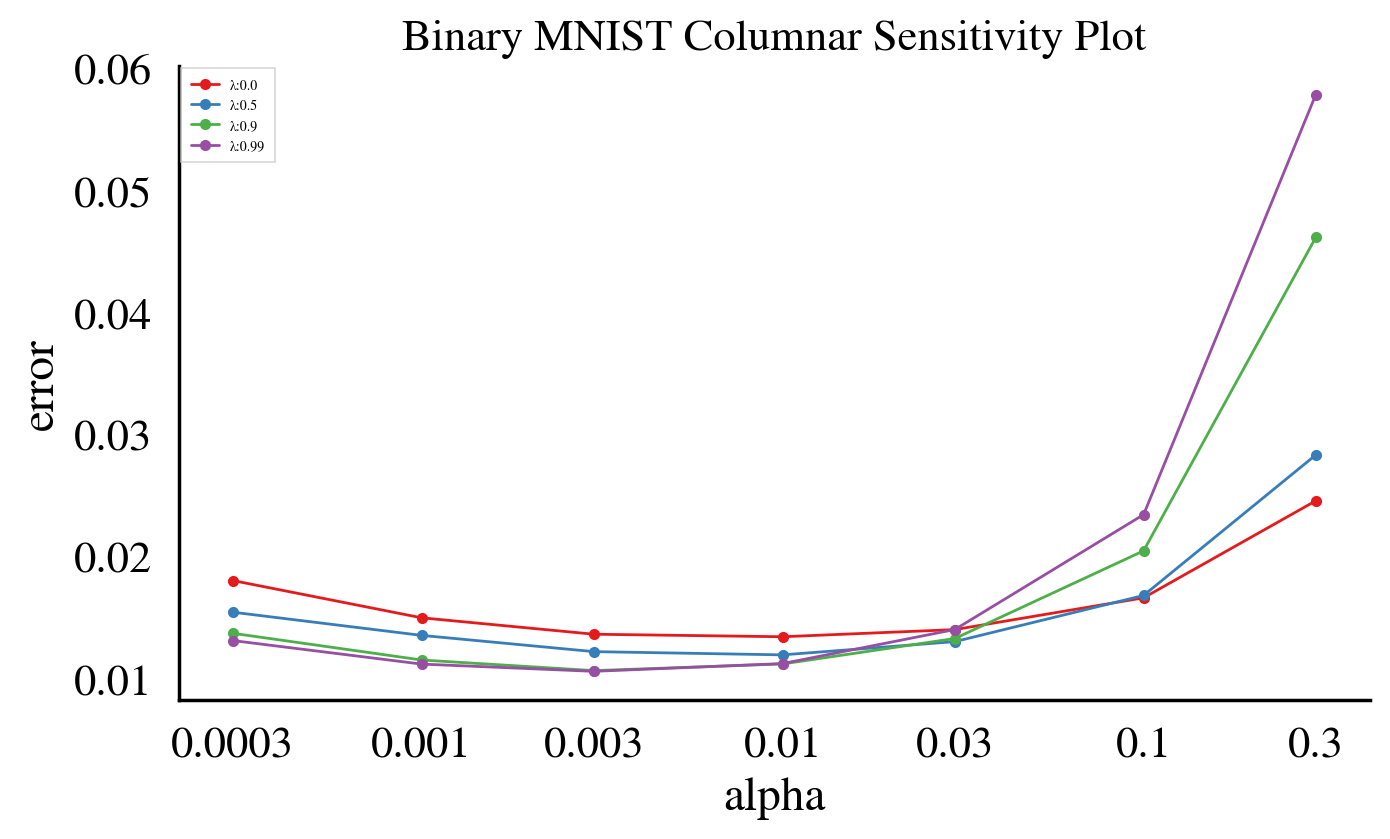

In [10]:
plt_name = f'Binary MNIST Columnar Sensitivity Plot'
fig = plt.figure(dpi=200)
plt.title(plt_name)
plt.xlabel('alpha')
plt.ylabel('error')

colors = plt.cycler(color=sns.color_palette("Set1",  n_colors=9)).by_key()['color']
color_idx = 0

mean_errors = []
runs = pd.read_sql(f'select run, step_size, lambda from runs where width=200', db1.conn)
p1 = np.unique(runs.values[:,1])
p2 = np.unique(runs.values[:,2])
for p in itertools.product(p1,p2):
    all_errors = []
    r = runs[(runs["step_size"] == p[0]) & (runs["lambda"] == p[1])]
    for run in r["run"].values:
        final_error = pd.read_sql(f'select error from error_table where run={run}', db1.conn).values[400][0]
        all_errors.append(final_error)
    all_errors = list(filter(lambda v: v==v, all_errors))
    mean_errors.append(np.concatenate((p, [np.mean(all_errors)])))
    print(p, ":\t", all_errors)
#pd.read_sql(f'select error from error_table where run=0', db1.conn).values[400]
r["run"].values
mean_errors = np.array(mean_errors)

for p in p2:
    values = mean_errors[mean_errors[:,1] == p]
    plt.plot(values[:,0], values[:,2], label=f"λ:{p}", color=colors[color_idx], linewidth=1, marker='.')
    color_idx += 1

plt.xscale('log')
plt.xticks(values[:,0], values[:,0])
fig.axes[0].set_ylim(bottom=0.00, top=0.05)
legend = plt.legend(prop={'size': 5})
frame = legend.get_frame()
#frame.set_edgecolor('black')
frame.set_linewidth(0.6)
frame.set_boxstyle('Square')

In [11]:
len(pd.read_sql(f'select error from error_table where run={run}', db1.conn).values)

417

(0.0003, 0.0) :	 10000 	 [0.025004, 0.02606, 0.025148, 0.025661, 0.025022, 0.026528, 0.024022, 0.025498, 0.024443, 0.026825]
(0.0003, 0.5) :	 10000 	 [0.0243, 0.025426, 0.024569, 0.02484, 0.024406, 0.026041, 0.023512, 0.025298, 0.023981, 0.026154]
(0.0003, 0.9) :	 10000 	 [0.023653, 0.02425, 0.023824, 0.02414, 0.023615, 0.025537, 0.022752, 0.024743, 0.023146, 0.025557]
(0.0003, 0.99) :	 10000 	 [0.023222, 0.023556, 0.023465, 0.024079, 0.023298, 0.024906, 0.021931, 0.022848, 0.022444, 0.025514]
(0.001, 0.0) :	 10000 	 [0.025172, 0.02374, 0.025042, 0.02422, 0.026248, 0.023877, 0.025206, 0.024891, 0.024757, 0.023828]
(0.001, 0.5) :	 10000 	 [0.023585, 0.022381, 0.023739, 0.023137, 0.025112, 0.023055, 0.023652, 0.0231, 0.02335, 0.023528]
(0.001, 0.9) :	 10000 	 [0.023384, 0.020801, 0.023063, 0.020882, 0.02434, 0.02232, 0.023237, 0.022153, 0.022964, 0.022821]
(0.001, 0.99) :	 10000 	 [0.02362, 0.020207, 0.022202, 0.021029, 0.023918, 0.021729, 0.022312, 0.021924, 0.021269, 0.021492]
(0.003, 

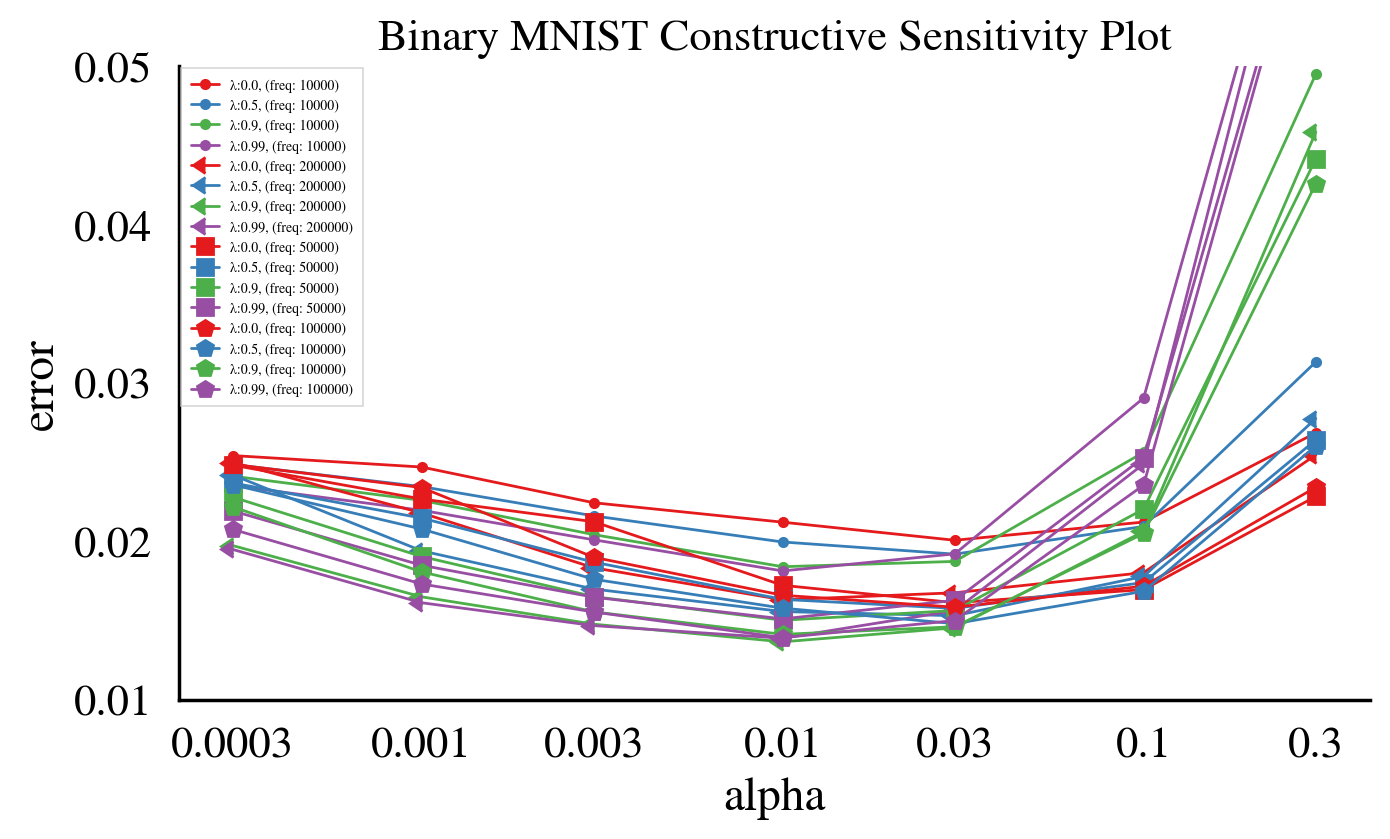

In [12]:
markers = ['.',8,'s','p','*','h']

marker_idx = 0

plt_name = f'Binary MNIST Constructive Sensitivity Plot'
fig = plt.figure(dpi=200)
plt.title(plt_name)
plt.xlabel('alpha')
plt.ylabel('error')

for freq in pd.read_sql(f'select distinct(freq) from runs where width=1', db1.conn).values.squeeze():
    colors = plt.cycler(color=sns.color_palette("Set1",  n_colors=9)).by_key()['color']
    color_idx = 0
    mean_errors = []
    runs = pd.read_sql(f'select run, step_size, lambda from runs where width=1 and freq={freq}', db1.conn)
    p1 = np.unique(runs.values[:,1])
    p2 = np.unique(runs.values[:,2])
    for p in itertools.product(p1,p2):
        all_errors = []
        r = runs[(runs["step_size"] == p[0]) & (runs["lambda"] == p[1])]
        for run in r["run"].values:
            errors_list = pd.read_sql(f'select error from error_table where run={run}', db1.conn).values
            if len(errors_list) >= 400:
                all_errors.append(errors_list[400][0])
        all_errors = list(filter(lambda v: v==v, all_errors))
        mean_errors.append(np.concatenate((p, [np.mean(all_errors)])))
        print(p, ":\t", freq, "\t", all_errors)
    #pd.read_sql(f'select error from error_table where run=0', db1.conn).values[400]
    r["run"].values
    mean_errors = np.array(mean_errors)

    for p in p2:
        values = mean_errors[mean_errors[:,1] == p]
        plt.plot(values[:,0], values[:,2], label=f"λ:{p}, (freq: {freq})", color=colors[color_idx], linewidth=1, marker=markers[marker_idx])#, markersize=2)
        color_idx += 1
    marker_idx += 1

plt.xscale('log')
plt.xticks(values[:,0], values[:,0])
fig.axes[0].set_ylim(bottom=0.00, top=0.05)
legend = plt.legend(prop={'size': 5})
frame = legend.get_frame()
#frame.set_edgecolor('black')
frame.set_linewidth(0.6)
frame.set_boxstyle('Square')
plt.show()

In [13]:
pd.read_sql(f'select run, step_size, lambda from runs where width=1 and freq={400000}', db1.conn)

,run,step_size,lambda


(0.0003, 0.0) :	 200000 	 [0.022409, 0.020862, 0.021661, 0.021821, 0.021542, 0.020915, 0.019628, 0.022065, 0.021258, 0.023796]
(0.0003, 0.5) :	 200000 	 [0.021836, 0.020247, 0.020172, 0.019224, 0.020213, 0.020135, 0.019032, 0.020834, 0.020666, 0.022492]
(0.0003, 0.9) :	 200000 	 [0.018321, 0.017817, 0.018222, 0.017829, 0.017391, 0.019024, 0.016885, 0.018679, 0.017389, 0.01997]
(0.0003, 0.99) :	 200000 	 [0.016847, 0.017027, 0.016548, 0.016676, 0.016868, 0.017733, 0.015016, 0.017223, 0.016213, 0.01902]
(0.001, 0.0) :	 200000 	 [0.020515, 0.01885, 0.020305, 0.018609, 0.01897, 0.019189, 0.017981, 0.019721, 0.019255, 0.020954]
(0.001, 0.5) :	 200000 	 [0.01719, 0.016866, 0.017234, 0.016713, 0.016142, 0.017877, 0.015231, 0.017216, 0.016932, 0.018162]
(0.001, 0.9) :	 200000 	 [0.01461, 0.014282, 0.013961, 0.013442, 0.013036, 0.014311, 0.013234, 0.014807, 0.013734, 0.015634]
(0.001, 0.99) :	 200000 	 [0.013139, 0.013197, 0.013483, 0.013077, 0.013945, 0.013618, 0.011875, 0.014217, 0.012786, 0.

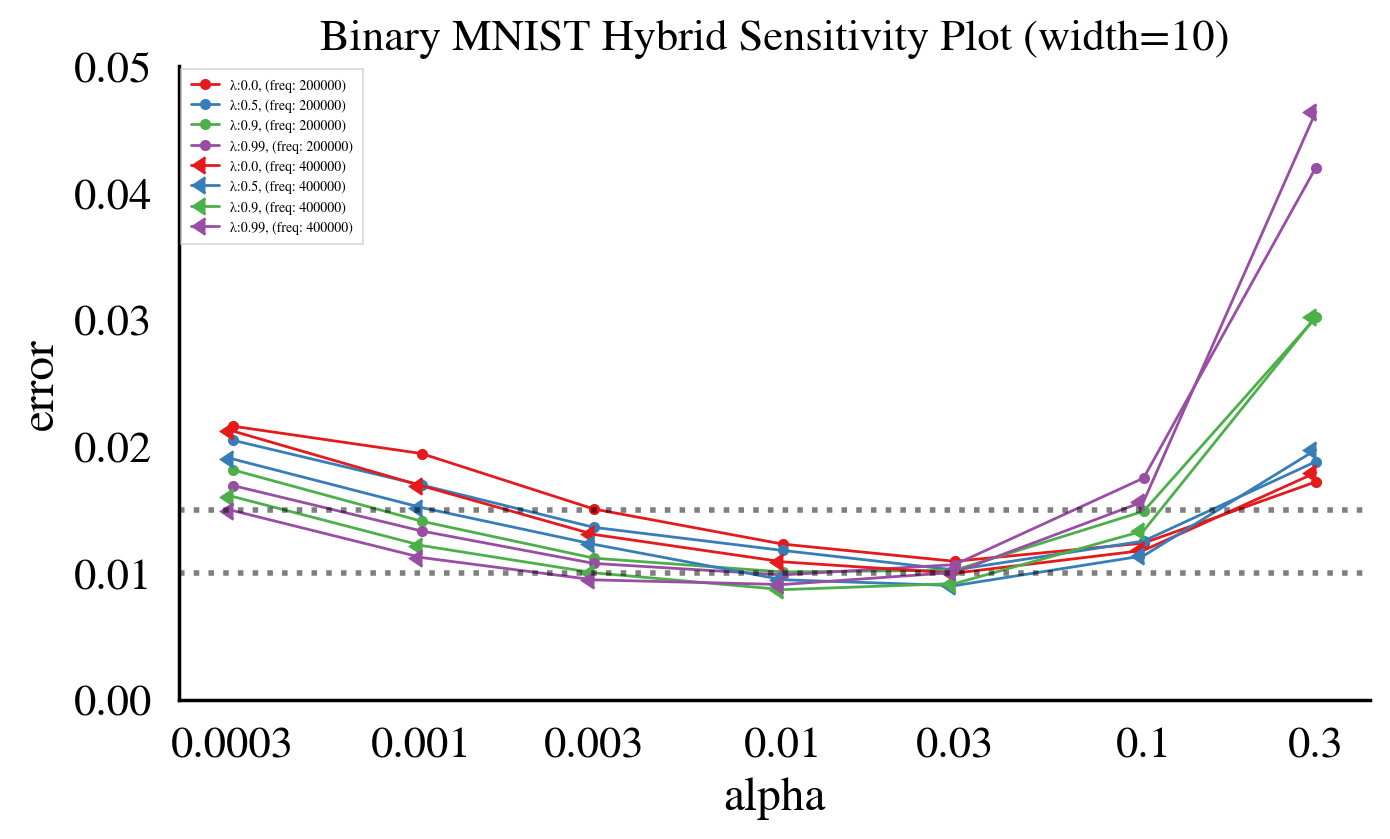

In [18]:
markers = ['.',8,'s','p','*','h']
marker_idx = 0
width=10

plt_name = f'Binary MNIST Hybrid Sensitivity Plot (width=10)'
fig = plt.figure(dpi=200)
plt.title(plt_name)
plt.xlabel('alpha')
plt.ylabel('error')

for freq in pd.read_sql(f'select distinct(freq) from runs where width={width}', db1.conn).values.squeeze():
    colors = plt.cycler(color=sns.color_palette("Set1",  n_colors=9)).by_key()['color']
    color_idx = 0
    mean_errors = []
    runs = pd.read_sql(f'select run, step_size, lambda from runs where width={width} and freq={freq}', db1.conn)
    p1 = np.unique(runs.values[:,1])
    p2 = np.unique(runs.values[:,2])
    for p in itertools.product(p1,p2):
        all_errors = []
        r = runs[(runs["step_size"] == p[0]) & (runs["lambda"] == p[1])]
        for run in r["run"].values:
            errors_list = pd.read_sql(f'select error from error_table where run={run}', db1.conn).values
            if len(errors_list) >= 400:
                all_errors.append(errors_list[400][0])
        all_errors = list(filter(lambda v: v==v, all_errors))
        mean_errors.append(np.concatenate((p, [np.mean(all_errors)])))
        print(p, ":\t", freq, "\t", all_errors)
    #pd.read_sql(f'select error from error_table where run=0', db1.conn).values[400]
    r["run"].values
    mean_errors = np.array(mean_errors)

    for p in p2:
        values = mean_errors[mean_errors[:,1] == p]
        plt.plot(values[:,0], values[:,2], label=f"λ:{p}, (freq: {freq})", color=colors[color_idx], linewidth=1, marker=markers[marker_idx])
        color_idx += 1
    marker_idx += 1

plt.xscale('log')
plt.xticks(values[:,0], values[:,0])
fig.axes[0].set_ylim(bottom=0.00, top=0.05)
legend = plt.legend(prop={'size': 5})
frame = legend.get_frame()
#frame.set_edgecolor('black')
frame.set_linewidth(0.6)
frame.set_boxstyle('Square')
plt.axhline(y=0.015, color='black', linestyle=':', linewidth=2, alpha=0.5)
plt.axhline(y=0.01, color='black', linestyle=':', linewidth=2, alpha=0.5)
plt.show()

(0.0003, 0.0) :	 200000 	 [0.023072, 0.022446, 0.022244, 0.022736, 0.021656, 0.022988, 0.020897, 0.023101, 0.02157, 0.023225]
(0.0003, 0.5) :	 200000 	 [0.021536, 0.021087, 0.02076, 0.021315, 0.019841, 0.021455, 0.019745, 0.021206, 0.020989, 0.022409]
(0.0003, 0.9) :	 200000 	 [0.019132, 0.018552, 0.017978, 0.017818, 0.017502, 0.018607, 0.016503, 0.019093, 0.016933, 0.018943]
(0.0003, 0.99) :	 200000 	 [0.01783, 0.017454, 0.016984, 0.017534, 0.016249, 0.017994, 0.016132, 0.018436, 0.016185, 0.017907]
(0.001, 0.0) :	 200000 	 [0.020323, 0.0192, 0.019333, 0.019382, 0.020462, 0.019842, 0.019514, 0.018487, 0.017972, 0.020805]
(0.001, 0.5) :	 200000 	 [0.017779, 0.016993, 0.016846, 0.017027, 0.017291, 0.01836, 0.016417, 0.017935, 0.016223, 0.01851]
(0.001, 0.9) :	 200000 	 [0.014598, 0.014845, 0.014542, 0.014459, 0.014595, 0.014865, 0.014103, 0.014999, 0.013494, 0.01461]
(0.001, 0.99) :	 200000 	 [0.013557, 0.014043, 0.01408, 0.01373, 0.014172, 0.013385, 0.012958, 0.014654, 0.012379, 0.0143

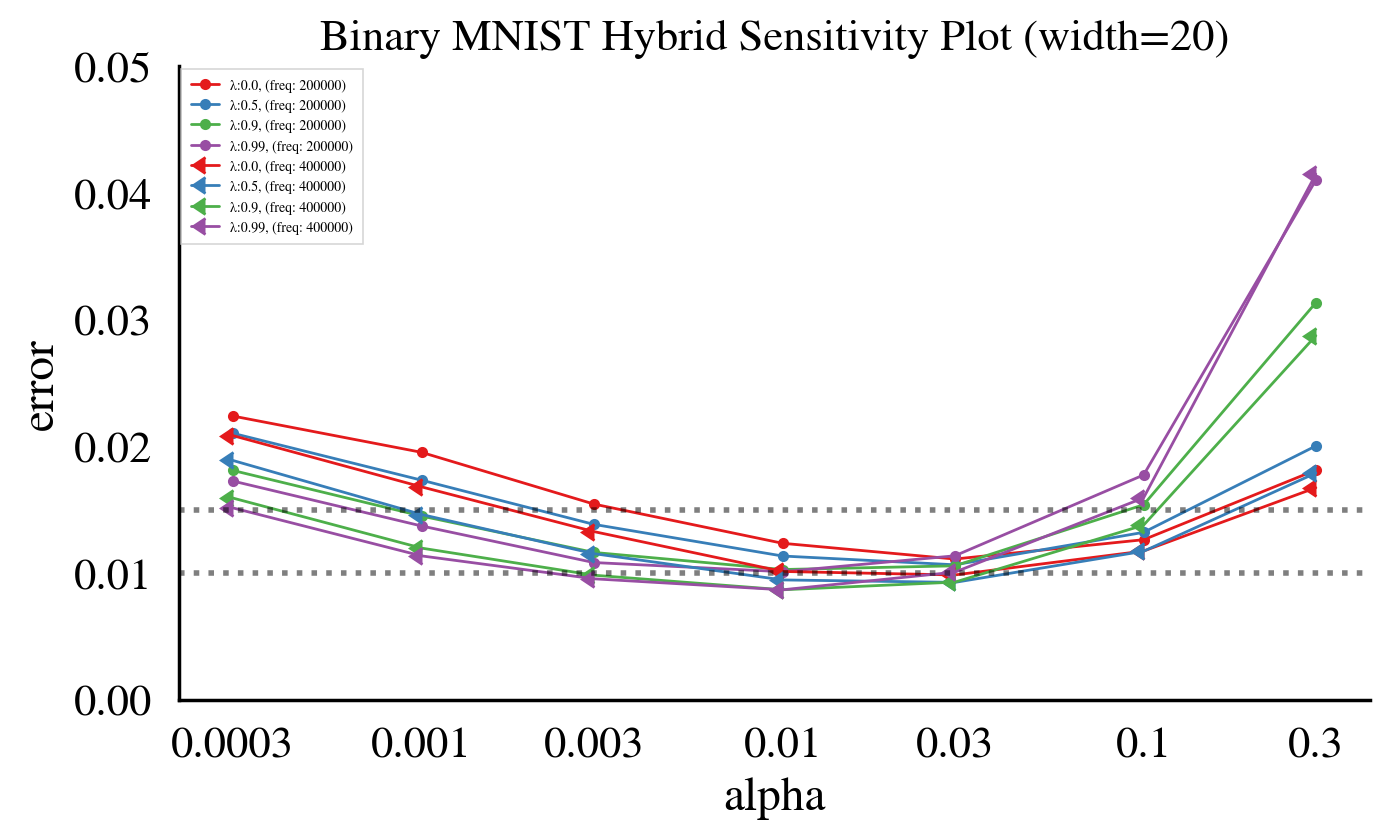

In [19]:
markers = ['.',8,'s','p','*','h']
marker_idx = 0
width=20

plt_name = f'Binary MNIST Hybrid Sensitivity Plot (width=20)'
fig = plt.figure(dpi=200)
plt.title(plt_name)
plt.xlabel('alpha')
plt.ylabel('error')

for freq in pd.read_sql(f'select distinct(freq) from runs where width={width}', db1.conn).values.squeeze():
    colors = plt.cycler(color=sns.color_palette("Set1",  n_colors=9)).by_key()['color']
    color_idx = 0
    mean_errors = []
    runs = pd.read_sql(f'select run, step_size, lambda from runs where width={width} and freq={freq}', db1.conn)
    p1 = np.unique(runs.values[:,1])
    p2 = np.unique(runs.values[:,2])
    for p in itertools.product(p1,p2):
        all_errors = []
        r = runs[(runs["step_size"] == p[0]) & (runs["lambda"] == p[1])]
        for run in r["run"].values:
            errors_list = pd.read_sql(f'select error from error_table where run={run}', db1.conn).values
            if len(errors_list) >= 400:
                all_errors.append(errors_list[400][0])
        all_errors = list(filter(lambda v: v==v, all_errors))
        mean_errors.append(np.concatenate((p, [np.mean(all_errors)])))
        print(p, ":\t", freq, "\t", all_errors)
    #pd.read_sql(f'select error from error_table where run=0', db1.conn).values[400]
    r["run"].values
    mean_errors = np.array(mean_errors)

    for p in p2:
        values = mean_errors[mean_errors[:,1] == p]
        plt.plot(values[:,0], values[:,2], label=f"λ:{p}, (freq: {freq})", color=colors[color_idx], linewidth=1, marker=markers[marker_idx])
        color_idx += 1
    marker_idx += 1

plt.xscale('log')
plt.xticks(values[:,0], values[:,0])
fig.axes[0].set_ylim(bottom=0.00, top=0.05)
legend = plt.legend(prop={'size': 5})
frame = legend.get_frame()
#frame.set_edgecolor('black')
frame.set_linewidth(0.6)
frame.set_boxstyle('Square')
plt.axhline(y=0.015, color='black', linestyle=':', linewidth=2, alpha=0.5)
plt.axhline(y=0.01, color='black', linestyle=':', linewidth=2, alpha=0.5)

plt.show()

	 Found 10 valid runs for [['width', 200], ['lambda', 0.99], ['step_size', 0.003]]
	 Found 10 valid runs for [['width', 1], ['lambda', 0.9], ['step_size', 0.01], ['freq', 200000]]
	 Found 10 valid runs for [['width', 10], ['lambda', 0.9], ['step_size', 0.01], ['freq', 400000]]


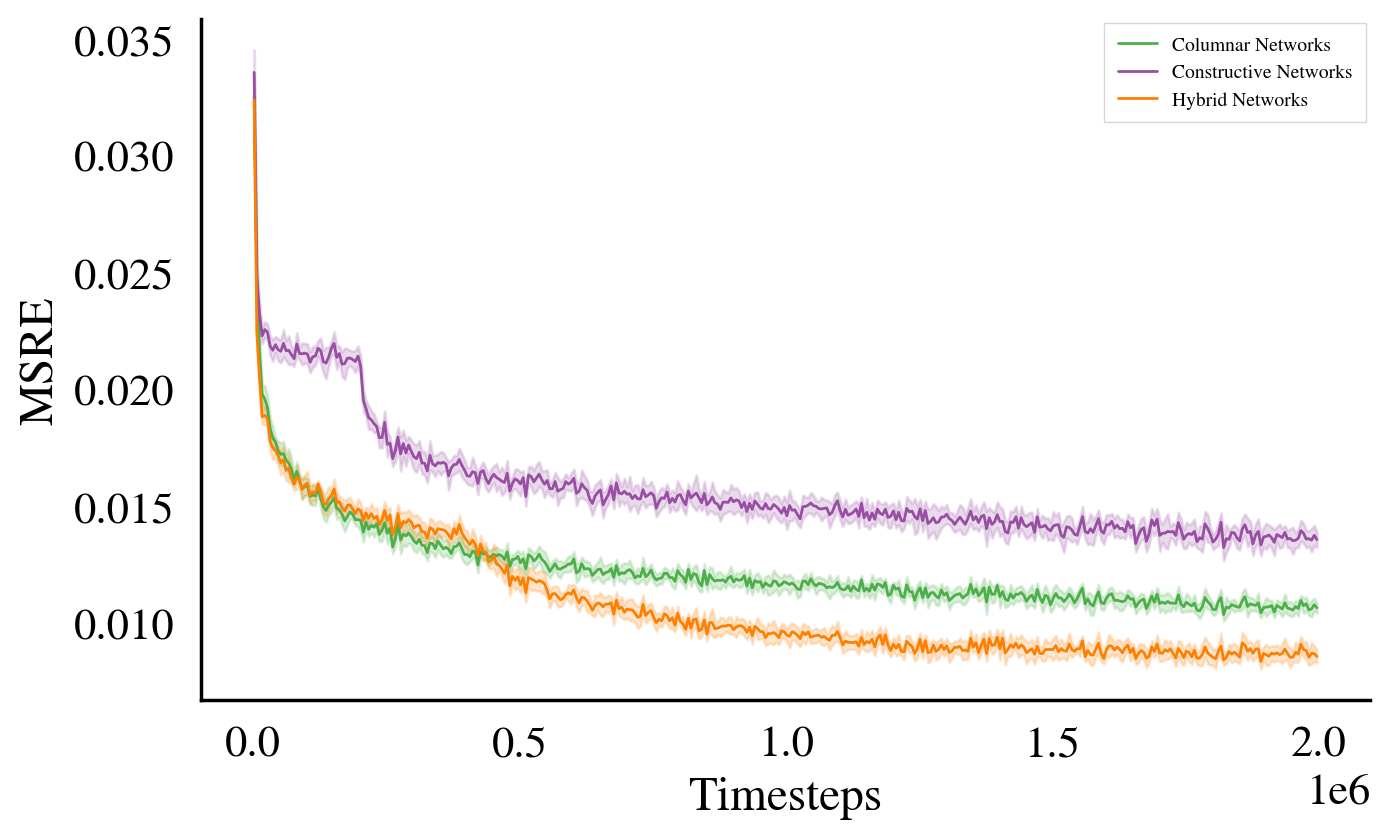

In [23]:

plt_name = f'Binary MNIST Task'
fig = plt.figure(dpi=200)
#plt.title(plt_name)
plt.xlabel('Timesteps')
plt.ylabel('MSRE')

colors = plt.cycler(color=sns.color_palette("Set1", n_colors=5)).by_key()['color']
#colors = plt.cycler(color=sns.color_palette("tab10", n_colors=4)).by_key()['color']
color_idx = 0
#conditions = [['step_size', 0.1],
#              ['lambda', 0.0],
#              ['truncation', 27]]
#plt_with_err("", 400, 0, db1, colors[color_idx], "Dense T-BPTT, k=27", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=1)
color_idx+=1

#conditions = [['lambda', 0.99],
#             ['step_size', 1e-2]]
#plt_with_err("", 98, 4500000, db4, colors[color_idx], "SnAp-1", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=1)
color_idx+=1

conditions = [['width', 200],
             ['lambda', 0.99],
             ['step_size', 0.003]]
plt_with_err("", 400,0, db1, colors[color_idx], "Columnar Networks", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=1)
color_idx+=1

conditions = [['width', 1],
             ['lambda', 0.9],
             ['step_size', 0.01],
             ['freq', 200000]]
plt_with_err("", 400,0, db1, colors[color_idx], "Constructive Networks", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=1)
color_idx+=1

conditions = [['width', 10],
             ['lambda', 0.9],
             ['step_size', 0.01],
             ['freq', 400000]]
plt_with_err("", 400,0, db1, colors[color_idx], "Hybrid Networks", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=1)
color_idx+=1

#plt.axhline(y=0.95, color='black', linestyle=':', linewidth=2, alpha=0.5)
legend = plt.legend(prop={'size': 7})
frame = legend.get_frame()
#frame.set_edgecolor('black')
frame.set_linewidth(0.5)
frame.set_boxstyle('Square')
plt.savefig('figures/plt_mnist.svg', bbox_inches='tight')
plt.show()

In [24]:
def plot_last_n_paper(obsall, predall, targets, n=400, colortarget=None, colorpred=None):
    fig, axs = plt.subplots(2,figsize=(7.2, 4.45), dpi=200)
    fig.tight_layout()#(7.2,4.45)
    axs[-2].step(list(range(n)), targets[-n:], color=colortarget)
    axs[-1].step(list(range(n)), predall[-n:], color=colorpred)
    axs[-2].set_ylabel('Target')
    axs[-1].set_ylabel('Prediction')
    axs[-1].set_xlabel('Timestep')

    for ax in axs:
        #ax.grid(color='#666666', linestyle='-', alpha=0.5)
        ax.label_outer()
    return fig

In [25]:
def plot_last_n_paper(n=400, db=None, condition=None, colortarget=None, colorpred=None, axs=None, seed=0):
    # too lazy
    seed = seed
    pkey_col = 'run'
    if condition == []:
        r = pd.read_sql(f'select {pkey_col} from runs and seed=0', db.conn).values
    elif len(condition) == 1:
        r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and seed={seed}', db.conn).values
    elif len(condition) == 2:
        r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} and seed={seed}', db.conn).values
    elif len(condition) == 3:
        r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} and {condition[2][0]} = {condition[2][1]} and seed={seed}', db.conn).values
    elif len(condition) == 4:
        r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} and {condition[2][0]} = {condition[2][1]} and {condition[3][0]} = {condition[3][1]} and seed={seed}', db.conn).values
    run = r[0][0]
    pred_table = pd.read_sql(f'select * from predictions where run={run}', db.conn)
    #obs = pred_table.values[:,2:9]
    pred = pred_table.values[:,-2]
    target = pred_table.values[:,-1]

    axs.step(list(range(n)), target[-n:], color=colortarget, alpha=0.2)
    axs.step(list(range(n)), pred[-n:], color=colorpred)
    #axs.set_ylabel('Target')
    #axs.set_ylabel('Prediction')
    #axs.set_xlabel('Timestep')

    #for ax in axs:
        #ax.grid(color='#666666', linestyle='-', alpha=0.5)
    #    ax.label_outer()
    return fig, pred, target

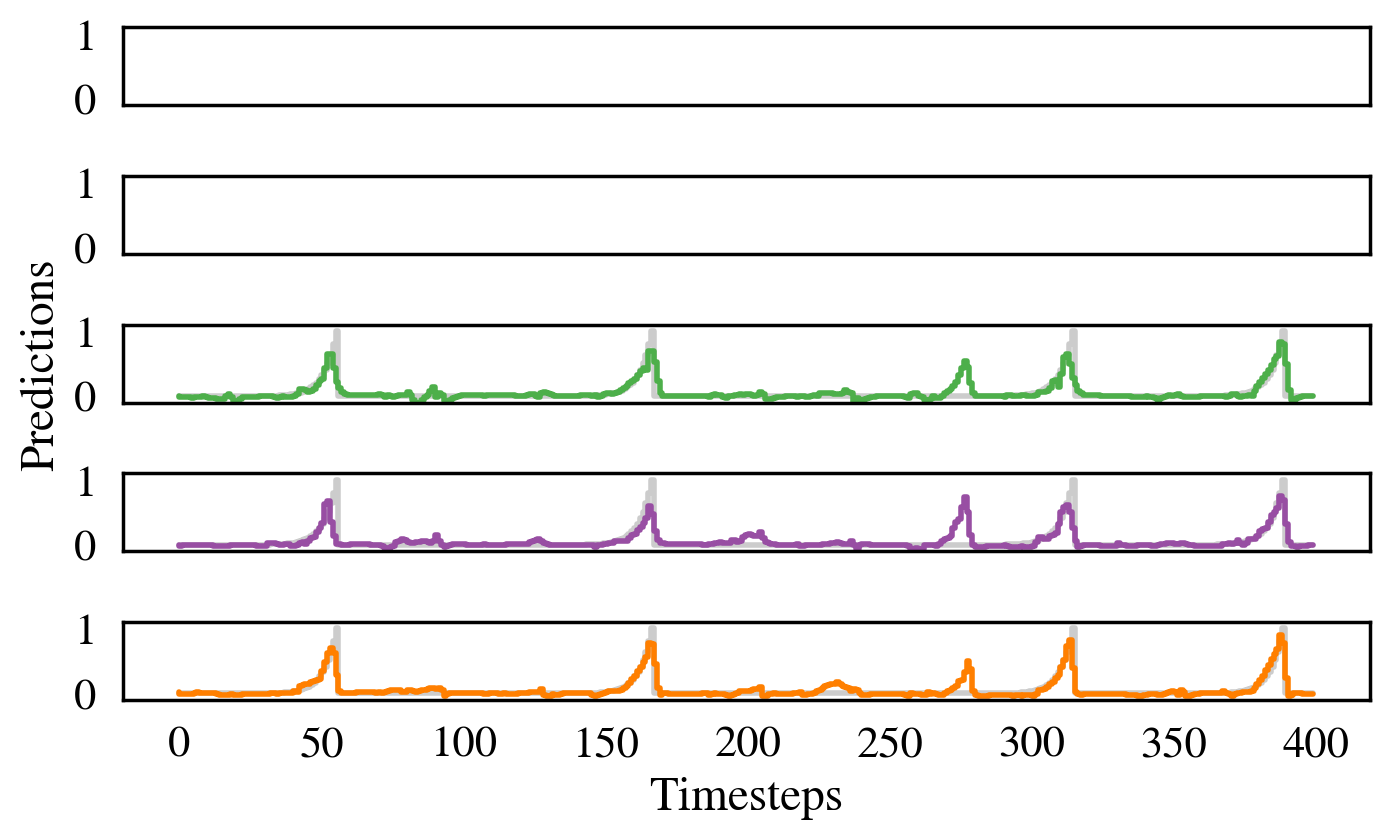

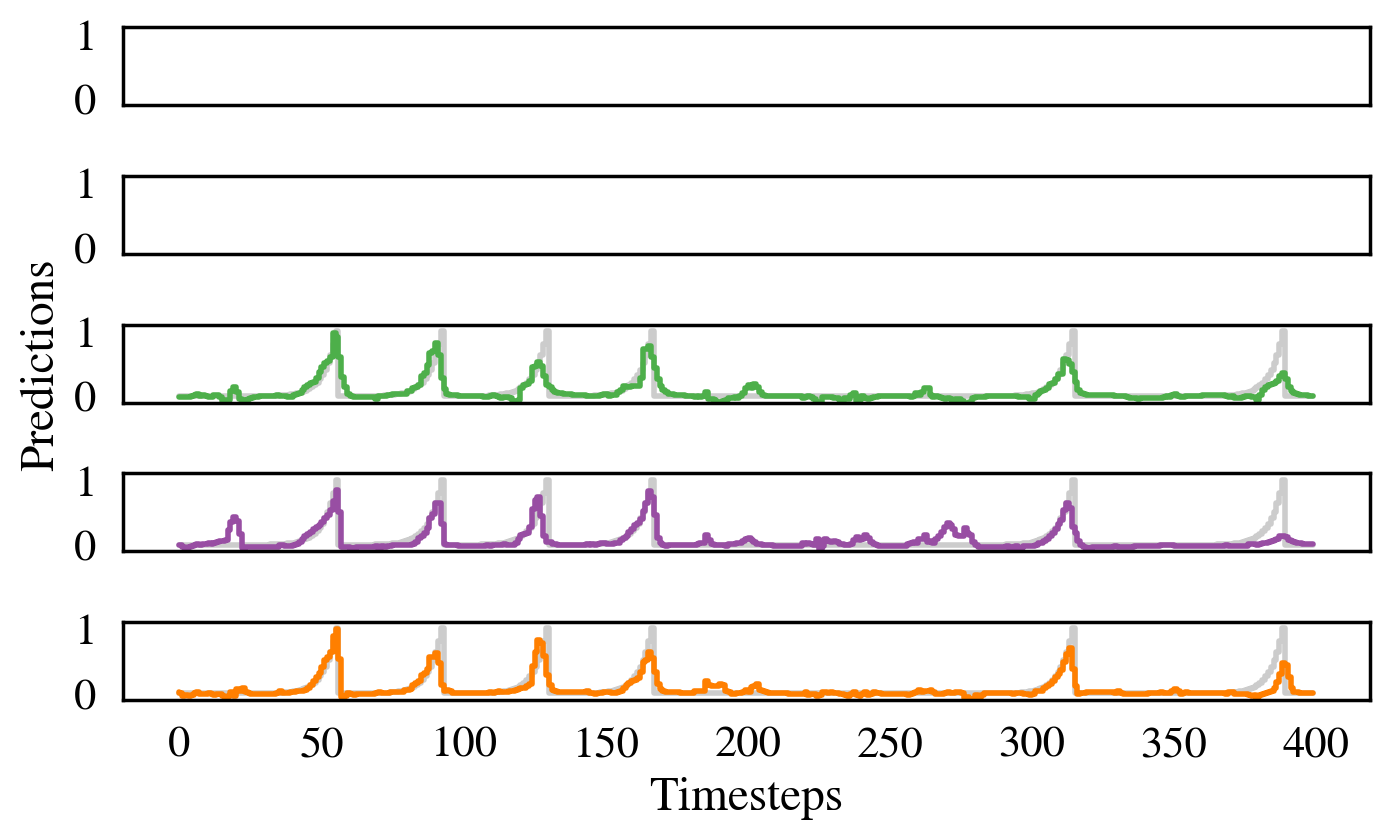

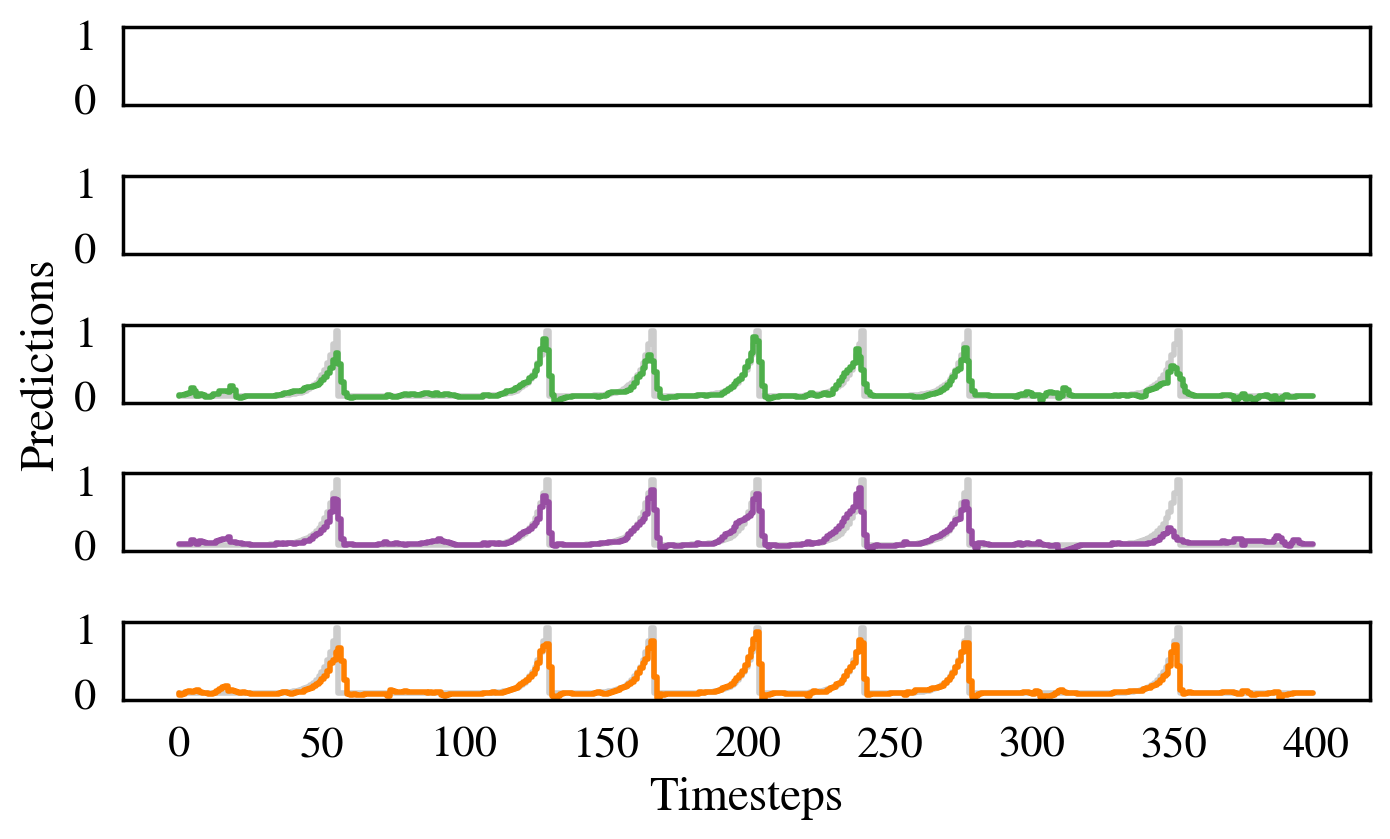

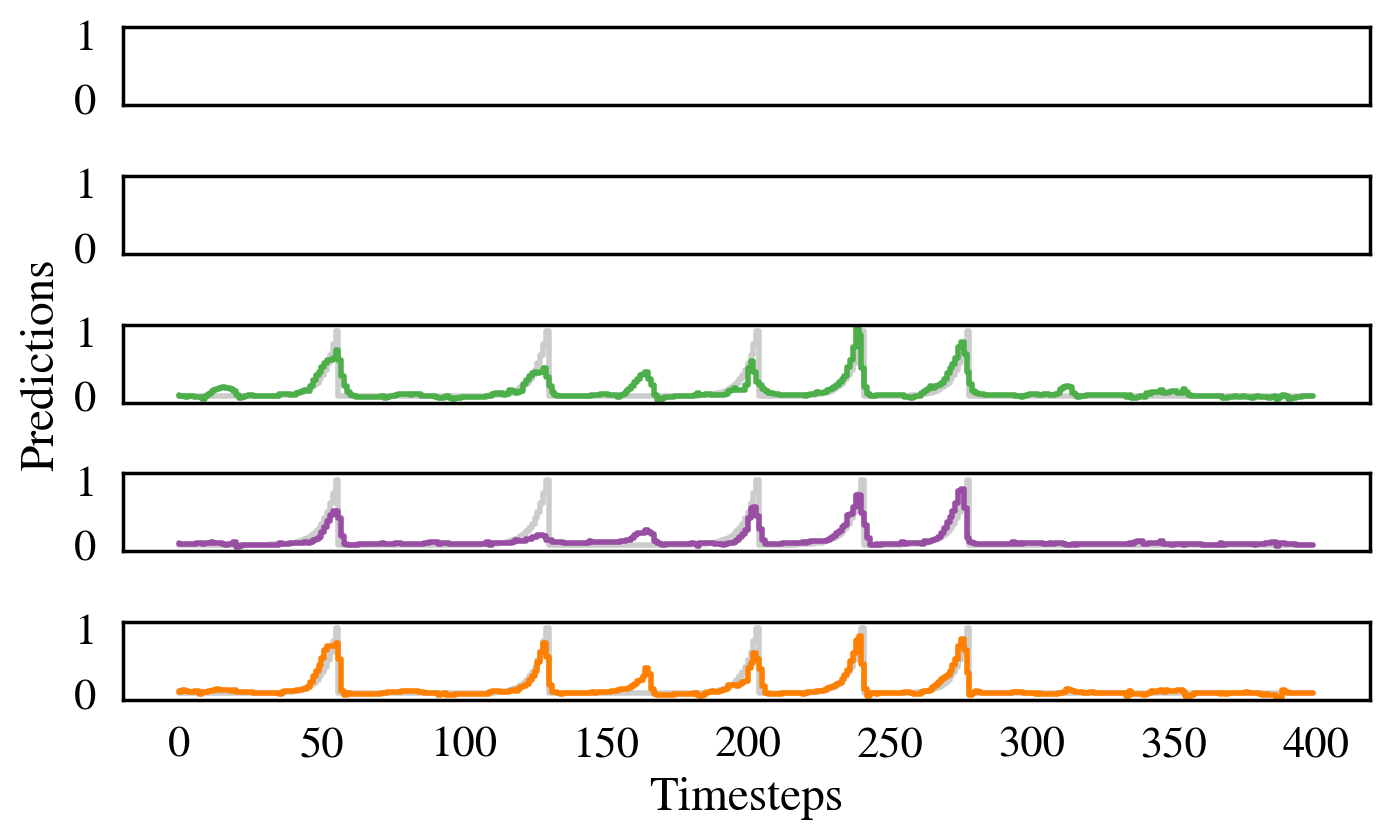

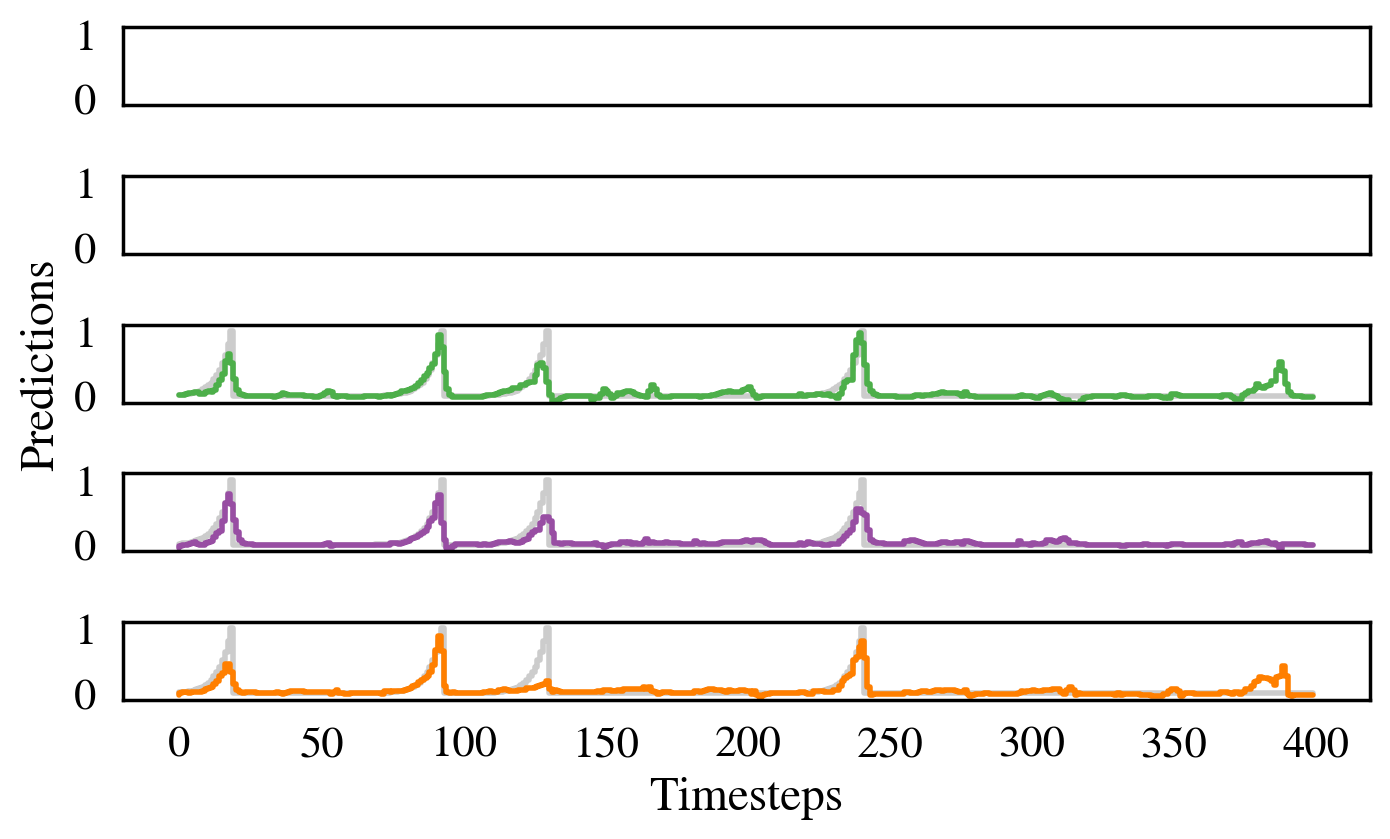

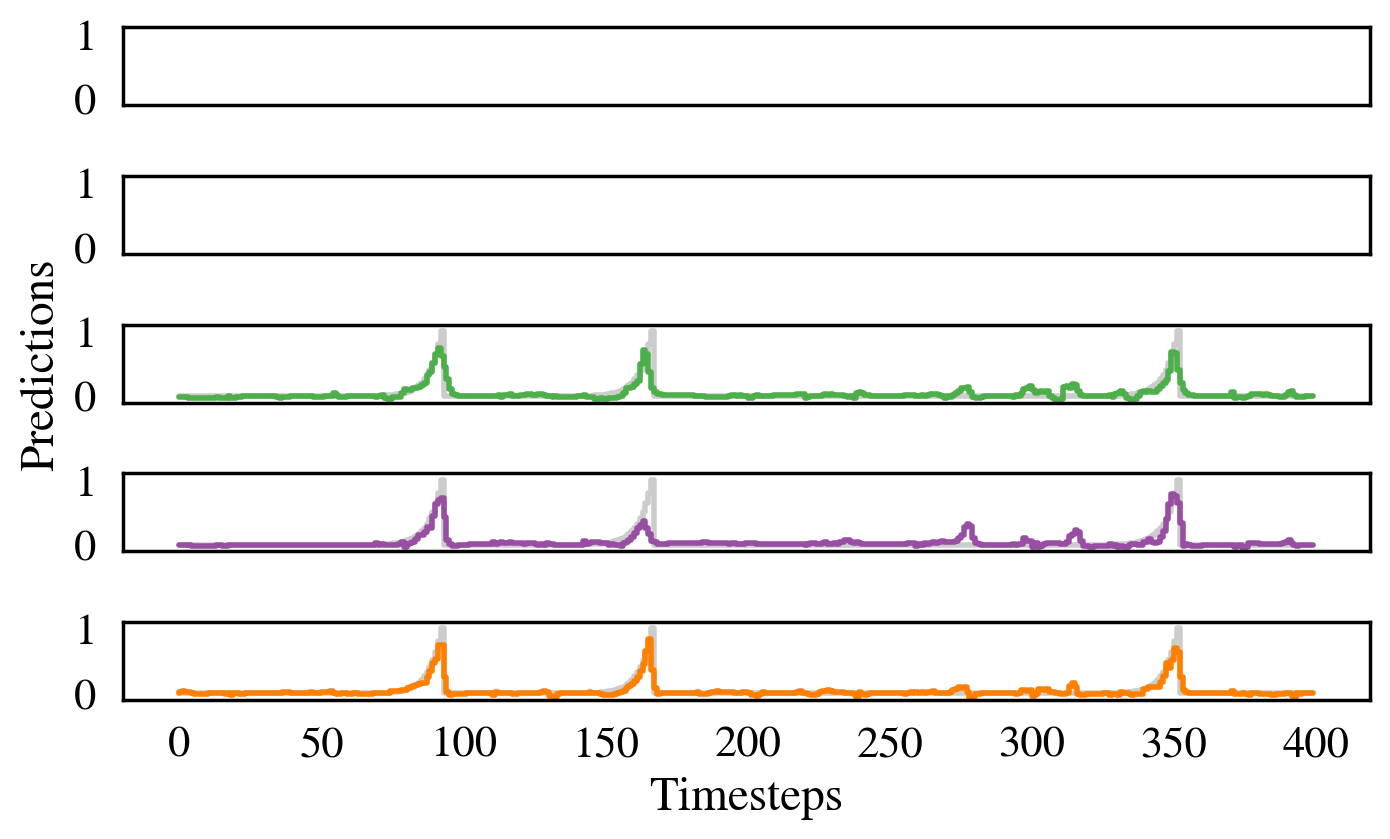

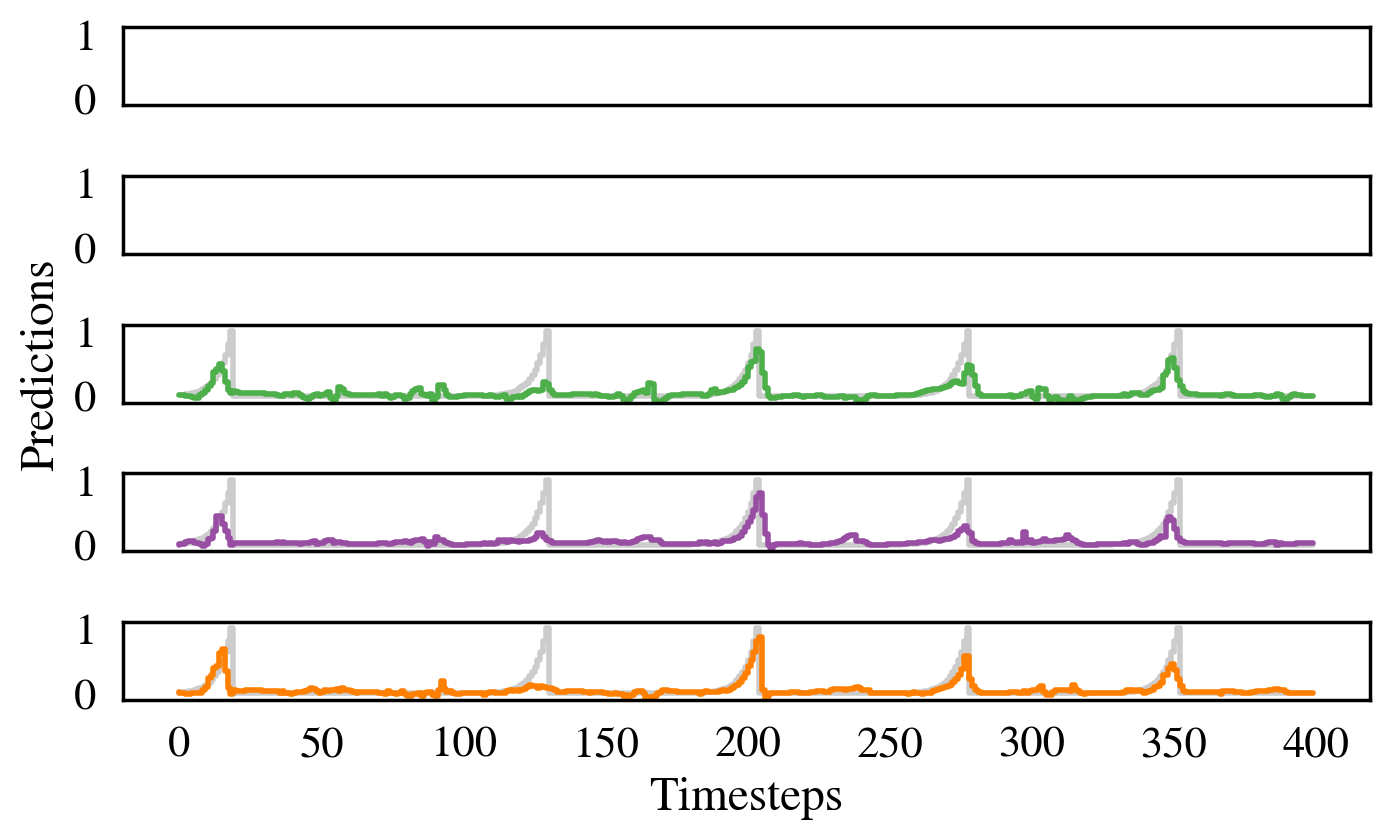

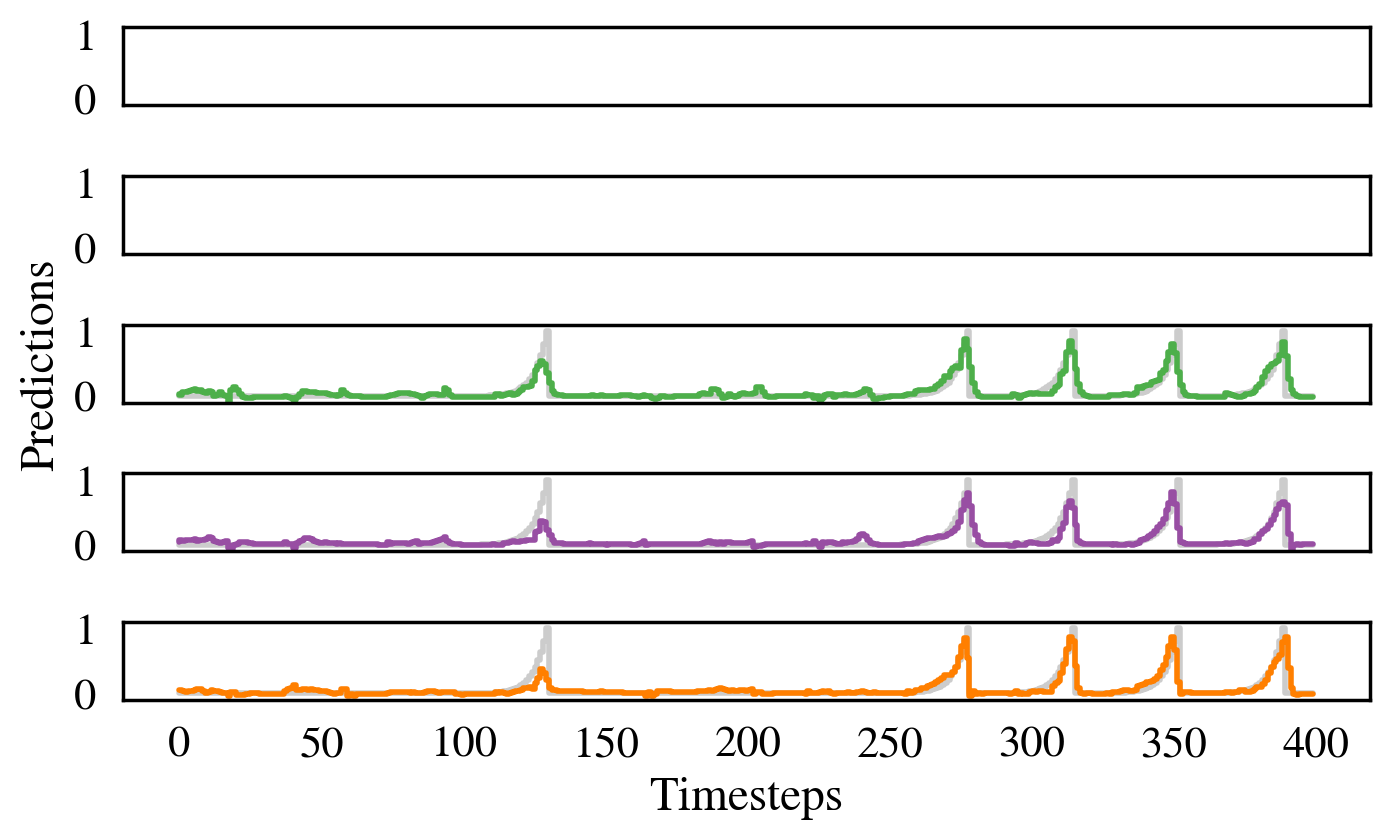

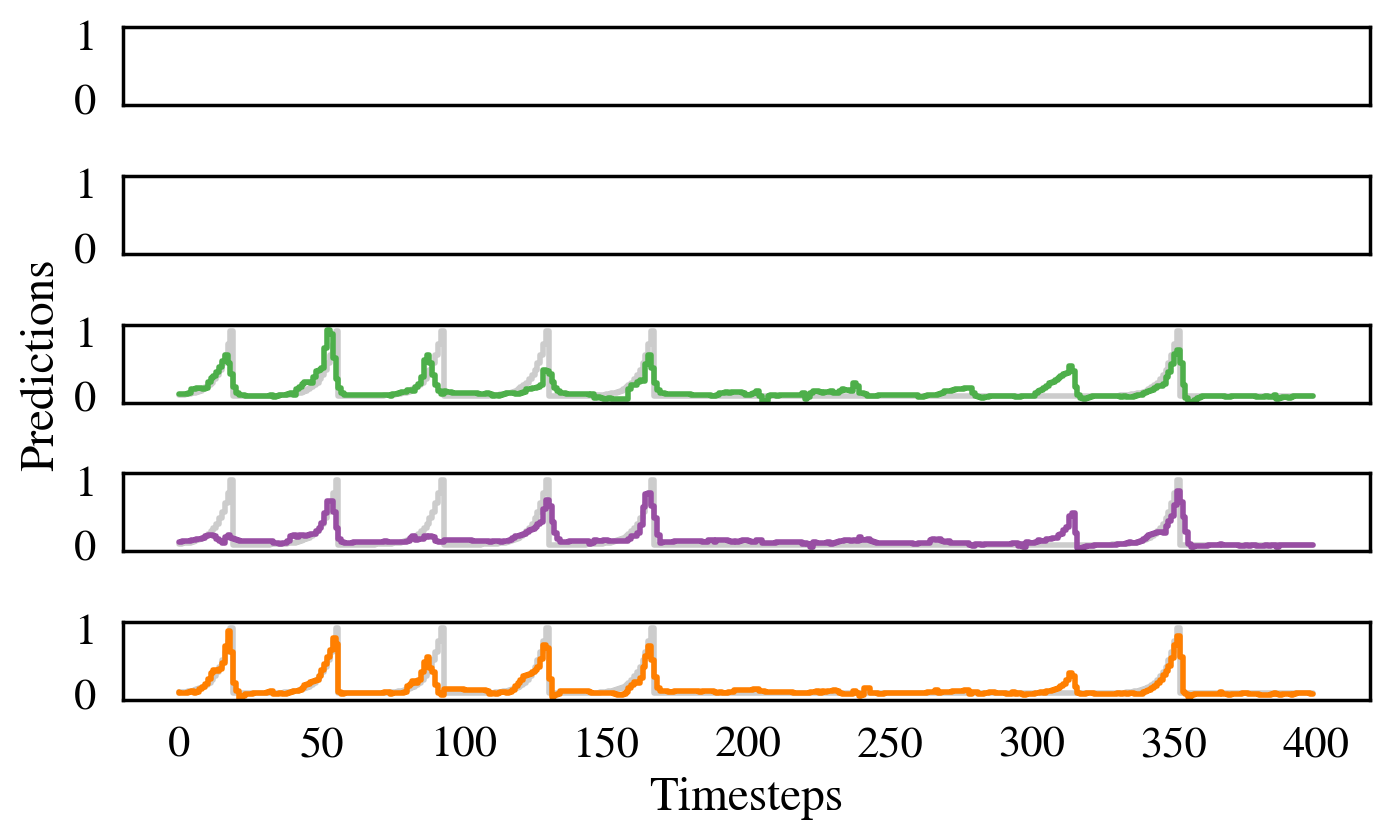

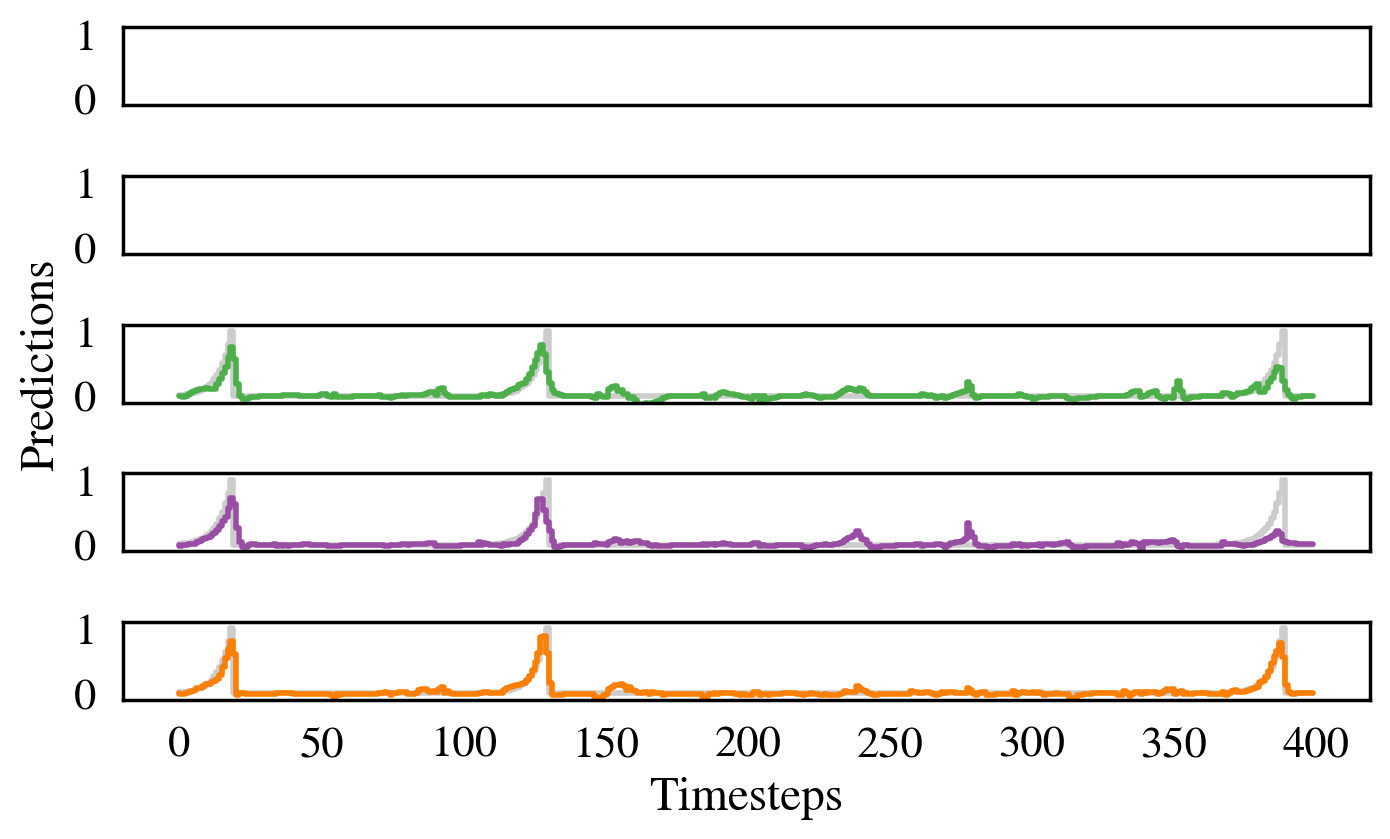

In [26]:
colors = plt.cycler(color=sns.color_palette("Set1",  n_colors=9)).by_key()['color']

for seed in [0,1,2,3,4,5,6,7,8,9]:
    fig, axs = plt.subplots(5,figsize=(7.2, 4.45), dpi=200)
    fig.tight_layout()
    """
    conditions = [['width', 20],
                 ['lambda', 0.99],
                 ['step_size', 1e-2],
                 ['freq', 800000]]
    colors = plt.cycler(color=sns.color_palette("Set1", n_colors=9)).by_key()['color']
    run = pd.read_sql(f'select run from runs where {conditions[0][0]} = {conditions[0][1]} and {conditions[1][0]} = {conditions[1][1]}  and {conditions[2][0]} = {conditions[2][1]}  and {conditions[3][0]} = {conditions[3][1]}', db2.conn).values[0][0]
    pred_table = pd.read_sql(f'select * from predictions where run={run}', db2.conn)
    obs = pred_table.values[:,2:9]
    pred = pred_table.values[:,9]
    target = pred_table.values[:,10]
    plot_last_n_paper(obs, pred, target, colortarget=colors[6], colorpred=colors[4], axs=axs[0])
    plot_last_n_paper(obs, pred, target, colortarget=colors[7], colorpred=colors[4], axs=axs[1])
    #plt.suptitle('Hybrid NNs')
    """

    color_idx = 0
    #conditions = [['step_size', 0.1],
    #              ['lambda', 0.0],
    #              ['truncation', 27]]
    #plot_last_n_paper(db=db1, condition=conditions, colortarget="black", colorpred=colors[color_idx], axs=axs[0])
    color_idx+=1

    #conditions = [['lambda', 0.99],
    #             ['step_size', 1e-2]]
    #plot_last_n_paper(db=db4, condition=conditions, colortarget="black", colorpred=colors[color_idx], axs=axs[1])
    color_idx+=1

    conditions = [['width', 200],
                 ['lambda', 0.99],
                 ['step_size', 0.003]]
    plot_last_n_paper(db=db1, condition=conditions, colortarget="black", colorpred=colors[color_idx], axs=axs[2], seed=seed)
    color_idx+=1

    conditions = [['width', 1],
                 ['lambda', 0.9],
                 ['step_size', 0.01],
                 ['freq', 200000]]
    plot_last_n_paper(db=db1, condition=conditions, colortarget="black", colorpred=colors[color_idx], axs=axs[3], seed=seed)
    color_idx+=1

    conditions = [['width', 10],
                 ['lambda', 0.9],
                 ['step_size', 0.01],
                 ['freq', 400000]]
    plot_last_n_paper(db=db1, condition=conditions, colortarget="black", colorpred=colors[color_idx], axs=axs[4], seed=seed)
    color_idx+=1
    for ax in axs:
        #ax.grid(color='#666666', linestyle='-', alpha=0.5)
        ax.label_outer()
        ax.set_ylim(bottom=-0.1, top=1.1)
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)
    axs[2].set_ylabel("Predictions")
    plt.xlabel("Timesteps")
    plt.savefig('figures/plt_mnist_preds.svg', bbox_inches='tight')

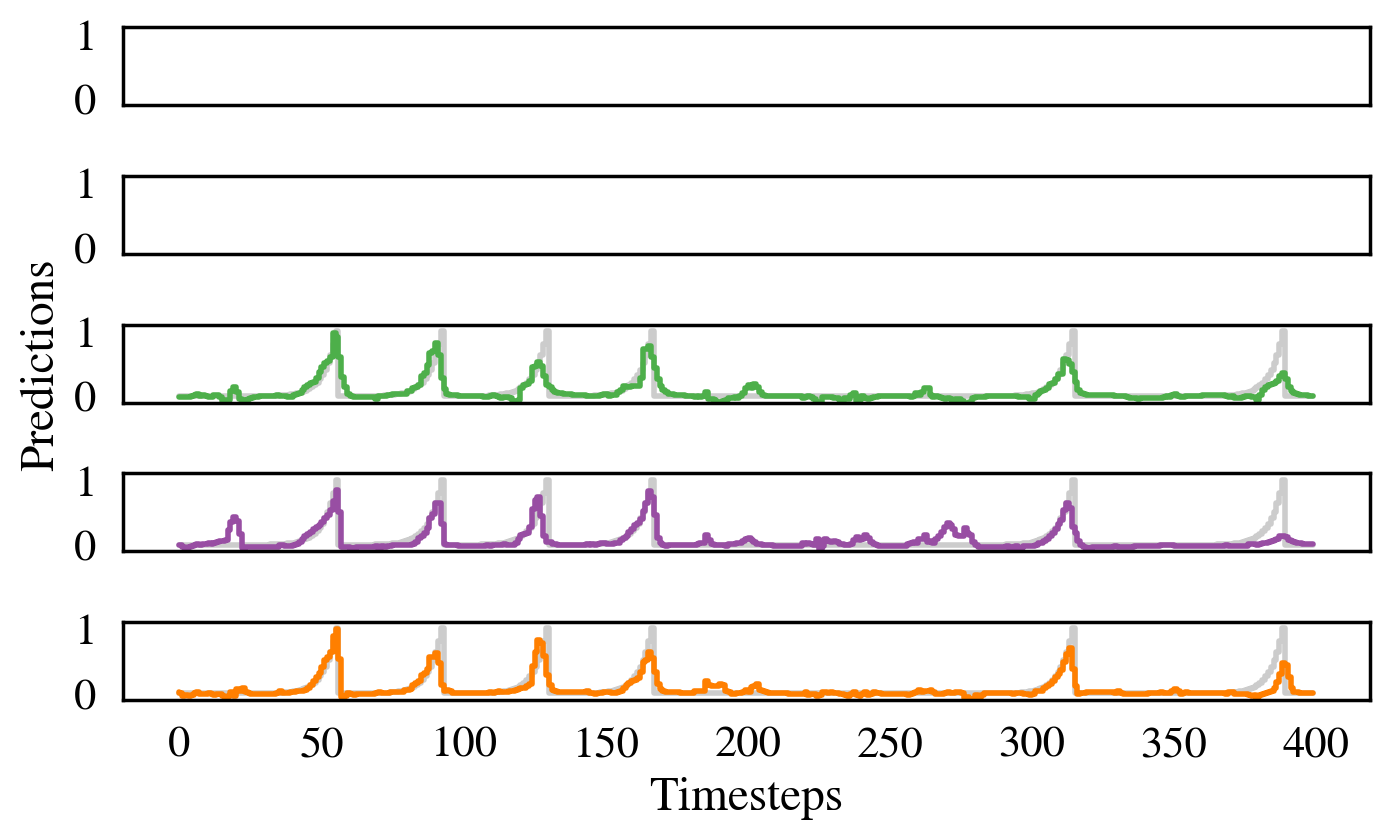

In [27]:
colors = plt.cycler(color=sns.color_palette("Set1",  n_colors=9)).by_key()['color']

for seed in [1]:
    fig, axs = plt.subplots(5,figsize=(7.2, 4.45), dpi=200)
    fig.tight_layout()
    """
    conditions = [['width', 20],
                 ['lambda', 0.99],
                 ['step_size', 1e-2],
                 ['freq', 800000]]
    colors = plt.cycler(color=sns.color_palette("Set1", n_colors=9)).by_key()['color']
    run = pd.read_sql(f'select run from runs where {conditions[0][0]} = {conditions[0][1]} and {conditions[1][0]} = {conditions[1][1]}  and {conditions[2][0]} = {conditions[2][1]}  and {conditions[3][0]} = {conditions[3][1]}', db2.conn).values[0][0]
    pred_table = pd.read_sql(f'select * from predictions where run={run}', db2.conn)
    obs = pred_table.values[:,2:9]
    pred = pred_table.values[:,9]
    target = pred_table.values[:,10]
    plot_last_n_paper(obs, pred, target, colortarget=colors[6], colorpred=colors[4], axs=axs[0])
    plot_last_n_paper(obs, pred, target, colortarget=colors[7], colorpred=colors[4], axs=axs[1])
    #plt.suptitle('Hybrid NNs')
    """

    color_idx = 0
    #conditions = [['step_size', 0.1],
    #              ['lambda', 0.0],
    #              ['truncation', 27]]
    #plot_last_n_paper(db=db1, condition=conditions, colortarget="black", colorpred=colors[color_idx], axs=axs[0])
    color_idx+=1

    #conditions = [['lambda', 0.99],
    #             ['step_size', 1e-2]]
    #plot_last_n_paper(db=db4, condition=conditions, colortarget="black", colorpred=colors[color_idx], axs=axs[1])
    color_idx+=1

    conditions = [['width', 200],
                 ['lambda', 0.99],
                 ['step_size', 0.003]]
    _, p, t = plot_last_n_paper(db=db1, condition=conditions, colortarget="black", colorpred=colors[color_idx], axs=axs[2], seed=seed)
    color_idx+=1

    conditions = [['width', 1],
                 ['lambda', 0.9],
                 ['step_size', 0.01],
                 ['freq', 200000]]
    plot_last_n_paper(db=db1, condition=conditions, colortarget="black", colorpred=colors[color_idx], axs=axs[3], seed=seed)
    color_idx+=1

    conditions = [['width', 10],
                 ['lambda', 0.9],
                 ['step_size', 0.01],
                 ['freq', 400000]]
    plot_last_n_paper(db=db1, condition=conditions, colortarget="black", colorpred=colors[color_idx], axs=axs[4], seed=seed)
    color_idx+=1
    for ax in axs:
        #ax.grid(color='#666666', linestyle='-', alpha=0.5)
        ax.label_outer()
        ax.set_ylim(bottom=-0.1, top=1.1)
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)
    axs[2].set_ylabel("Predictions")
    plt.xlabel("Timesteps")
    plt.savefig('figures/plt_mnist_preds.svg', bbox_inches='tight')

In [20]:
np.set_printoptions(threshold=sys.maxsize)
print(t[-400:])

[0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.002418 0.003022 0.003778 0.004722
 0.005903 0.007379 0.009223 0.011529 0.014412 0.018014 0.022518 0.028148
 0.035184 0.04398  0.054976 0.068719 0.085899 0.107374 0.134218 0.167772
 0.209715 0.262144 0.32768  0.4096   0.512    0.64     0.8      1.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.002418 0.003022 0.003778 0.004722 0.005903 0.007379
 0.009223 0.011529 0.014412 0.018014 0.022518 0.028148 0.035184 0.04398
 0.054976 0.068719 0.085899 0.107374 0.134218 0.167772 0.209715 0.262144
 0.32768  0.4096   0.512    0.64     0.8      1.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.002418 0.003022 0.003778 0.004722 0.005903 0.007379 0.009223 0.011529
 0.014412 0.018014 0.022518 0.028148 0.035184 0.04398  0.054976 0.068719
 0.085899 0.107